# Try to calculate the midpoint of a collection of nodes.

In [1]:
import pandas as pd
import networkx as nx

import seaborn as sns
from matplotlib import pyplot as plt

import re

In [2]:
file_path = '../data/mrt.xlsx'
mrt_excel = pd.read_excel(file_path, sheet_name=None)
mrt_df = mrt_excel['Master List']
mrt_df.head()

,Column1,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,LINE,TIMING_TO_NEXT,NEXT
0,0.0,12.0,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,NS,195.0,NS11
1,1.0,16.0,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,EW,151.0,EW10
2,2.0,33.0,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,NS,217.0,NS17
3,3.0,81.0,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS,NaN,NaN
4,4.0,80.0,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS,NaN,NaN


### Define the graph

In [2]:
G = nx.Graph()

### Add nodes.

Note that each line within a station is it's own node (e.g. Raffles Place NS26 and EW14 are separate nodes.) This allows us more flexibility in defining the edges later.

In [3]:
for i, row in mrt_df.iterrows():
    if row['LINE'] == 'OTHERS':
        continue
    key = row['STN_NO']
    info = {'STN_NAME': row['STN_NAME'], 'LINE': row['LINE']}

    G.add_node(key,**info)

NameError: name 'mrt_df' is not defined

### Add edges.

Each edge has two properties: 
- weight (representing time to travel between nodes)
- line (MRT line. If it's a transfer station, the value is 'interchange').

#### Add edges connecting lines within the same station.

  Data taken from someone.

In [ ]:
interchange_timing_df = mrt_excel['Transfer Timings']

In [6]:
for i, row in interchange_timing_df.iterrows():
    if row['Start Code'] not in list(G.nodes()) or row['End Code'] not in list(G.nodes()):
        continue

    edge = (row['Start Code'], row['End Code'])
    weight=row['Transfer time in seconds']
    line='transfer'
    G.add_edge(*edge, weight=weight)

#### Add edges between stations along the lines.

Data taken from someone who did a speedrun (rmb to credit him)

In [7]:
mean_time_between_stns = 148  # Use this for the edge weight if data not present.

In [8]:
def convert_to_seconds(timing_to_next: str)-> int:
    return int(timing_to_next[0])*60 + int(timing_to_next[2:4])

edges_df = mrt_df.loc[mrt_df['LINE'] != 'OTHERS']
edges_df = edges_df.dropna(subset=['NEXT'])
edges_df = edges_df.fillna(value={'TIMING_TO_NEXT': mean_time_between_stns})

In [9]:
for i, row in edges_df.iterrows():
    if row['STN_NO'] not in list(G.nodes()) or row['NEXT'] not in list(G.nodes()):
        continue
    G.add_edge(row['STN_NO'], row['NEXT'], weight=row['TIMING_TO_NEXT'], line=row['LINE'])

### Sanity Check 

Let's plot the network.

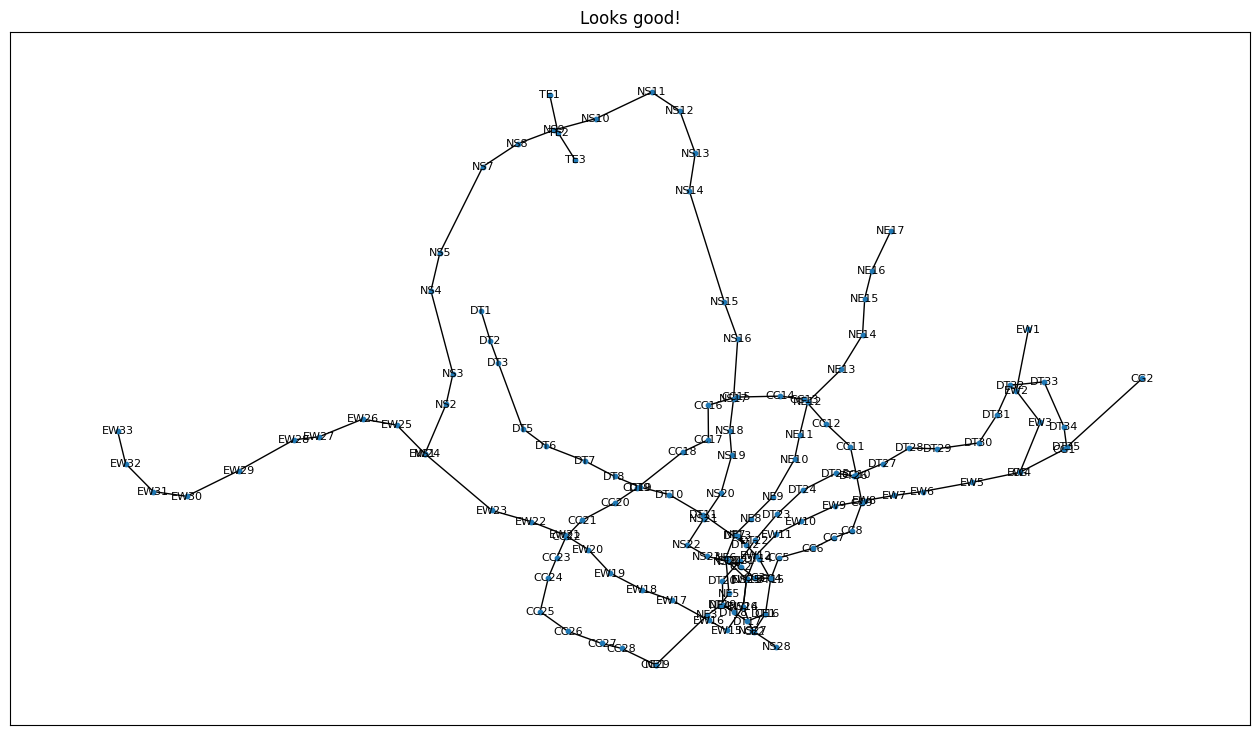

In [10]:
options = {
    'node_size': 10,
    'font_size': 8,
}

pos = {row['STN_NO']: (row['Longitude'], row['Latitude']) for i, row in mrt_df.iterrows() if row['STN_NO'] in list(G.nodes)}

plt.figure(figsize=(16,9))
nx.draw_networkx(G, pos=pos, **options)

plt.title('Looks good!')

plt.show()

In [30]:
paths = nx.johnson(G, weight="weight")

In [12]:
from networkx.classes.function import path_weight

In [13]:
path = ['NS17', 'NS16', 'NS15']
path_weight(G, path, weight='weight')

371.0

In [14]:
import statistics

In [23]:
def objective_function(data: list, l=0.01) -> float:
    return sum(data) + l * statistics.variance(data)

In [24]:
targets = ['DT28', 'NE11', 'EW1']

min_weight = 1e9
winning_station = ''

for station in paths:
    weights = []
    
    for target in targets:
        path = paths[station][target]
        weights.append(path_weight(G, path, weight='weight'))
    
    if objective_function(weights) < min_weight:
        min_weight = objective_function(weights)
        winning_station = station
        print(winning_station, objective_function(weights))

NS10 14002.653333333334
EW9 4329.743333333334
EW7 3529.0233333333335


In [25]:
winning_station

'EW7'

In [28]:
for target in targets:
    path_1 = paths[winning_station][target]
    print(target)
    print(path_weight(G, path_1, weight='weight'))

DT28
750.0
NE11
1176.0
EW1
1093.0


In [31]:
import json
with open('mrt_paths.json', 'w', encoding ='utf8') as json_file:
    json.dump(paths, json_file, ensure_ascii = False)